In [182]:
!pip3 install jraph flax optax clu networkx

/Users/augustfemtehjell/opt/miniconda3/envs/TSP-graph/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
import jraph
import numpy as np
import jax.numpy as jnp
from jraph import GraphsTuple
from matrix_helper import calculate_distances
from jax import Array, jit
from flax.typing import VariableDict
from flax.training import train_state
from clu import metrics
from functools import partial
import flax
import jax
from typing import Sequence, Callable, Any
from flax import linen as nn

In [423]:
def add_graphs_tuples(
    graphs: jraph.GraphsTuple, other_graphs: jraph.GraphsTuple
) -> jraph.GraphsTuple:
    """Adds the nodes, edges and global features from other_graphs to graphs."""
    return graphs._replace(
        nodes=graphs.nodes + other_graphs.nodes,
        edges=graphs.edges + other_graphs.edges,
        globals=graphs.globals + other_graphs.globals,
    )


class MLP(nn.Module):
    """A multi-layer perceptron."""

    feature_sizes: Sequence[int]
    dropout_rate: float = 0
    deterministic: bool = True
    activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu

    @nn.compact
    def __call__(self, inputs):
        x = inputs
        for size in self.feature_sizes:
            x = nn.Dense(features=size)(x)
            x = self.activation(x)
            # x = nn.Dropout(rate=self.dropout_rate,
            #                deterministic=self.deterministic)(x)
        return x


class GraphNet(nn.Module):
    """A complete Graph Network model defined with Jraph."""

    latent_size: int
    num_mlp_layers: int
    message_passing_steps: int
    num_nodes: int
    dropout_rate: float = 0
    skip_connections: bool = True
    use_edge_model: bool = True
    layer_norm: bool = True
    deterministic: bool = True

    @nn.compact
    def __call__(self, graphs: jraph.GraphsTuple) -> jraph.GraphsTuple:
        # We will first linearly project the original features as 'embeddings'.
        # embedder = jraph.GraphMapFeatures(
        #     embed_node_fn=nn.Dense(self.latent_size),
        #     embed_edge_fn=nn.Dense(self.latent_size),
        #     embed_global_fn=nn.Dense(self.latent_size),
        # )
        # embedder = jraph.GraphMapFeatures(
        #     embed_node_fn=nn.Dense(self.latent_size),
        #     embed_edge_fn=None,
        #     embed_global_fn=None,
        # )
        # processed_graphs = embedder(graphs)
        processed_graphs = graphs

        # Now, we will apply a Graph Network once for each message-passing round.
        mlp_feature_sizes = [self.latent_size] * self.num_mlp_layers
        for _ in range(self.message_passing_steps):
            if self.use_edge_model:
                update_edge_fn = jraph.concatenated_args(
                    MLP(
                        mlp_feature_sizes,
                        dropout_rate=self.dropout_rate,
                        deterministic=self.deterministic,
                    )
                )
            else:
                update_edge_fn = None

            # update_node_fn = jraph.concatenated_args(
            #     MLP(
            #         mlp_feature_sizes,
            #         dropout_rate=self.dropout_rate,
            #         deterministic=self.deterministic,
            #     )
            # )
            update_node_fn = None

            update_global_fn = jraph.concatenated_args(
                MLP(
                    mlp_feature_sizes,
                    dropout_rate=self.dropout_rate,
                    deterministic=self.deterministic,
                )
            )

            graph_net = jraph.GraphNetwork(
                update_node_fn=update_node_fn,
                update_edge_fn=update_edge_fn,
                update_global_fn=update_global_fn,
            )

            if self.skip_connections:
                processed_graphs = add_graphs_tuples(
                    graph_net(processed_graphs), processed_graphs
                )
            else:
                processed_graphs = graph_net(processed_graphs)

            if self.layer_norm:
                processed_graphs = processed_graphs._replace(
                    nodes=nn.LayerNorm()(processed_graphs.nodes),
                    edges=nn.LayerNorm()(processed_graphs.edges),
                    globals=nn.LayerNorm()(processed_graphs.globals),
                )

        def round_fn(x):
            return 1 / 2 + 1 / 2 * nn.tanh(10 * (x - 1 / 2))

        def decoder_fn(x):
            n = self.num_nodes
            x = nn.Dense(n * n)(x)
            # x = nn.sigmoid(x)
            # x = nn.softmax(x.reshape(n, n), axis=1)
            x = round_fn(x.flatten())
            return x
            # return round_fn(
            #     nn.softmax(nn.Dense(n * n)(x).reshape(n, n), axis=1).flatten()
            # )

        # Since our graph-level predictions will be at globals, we will
        # decode to get the required output logits.
        # decoder = jraph.GraphMapFeatures(
        #     embed_global_fn=MLP([self.num_nodes * self.num_nodes])
        # )

        decoder = jraph.GraphMapFeatures(embed_global_fn=decoder_fn)

        processed_graphs = decoder(processed_graphs)

        return processed_graphs

In [440]:
@flax.struct.dataclass
class TrainMetrics(metrics.Collection):
    loss: metrics.Average.from_output("loss")


@partial(jit, static_argnums=(2,))
def train_step(
    state: train_state.TrainState, graph: GraphsTuple, n: int, rngs: dict[str, Array]
) -> train_state.TrainState:
    # n = graph.n_node[0]

    # A = 100 * jnp.max(graph.edges)
    # B = 10
    A, B = 2, 1

    in_graph = jnp.zeros((n, n))
    not_in_graph = jnp.ones((n, n)) * A * 10
    # W = jnp.ones((n, n)) * A

    for point_a, point_b, edge in zip(graph.senders, graph.receivers, graph.edges):
        edge = edge[0]
        in_graph = in_graph.at[point_a, point_b].set(edge)
        not_in_graph = not_in_graph.at[point_a, point_b].set(0)

    # for point_a, point_b in zip(graph.senders, graph.receivers):
    #     edge = jnp.linalg.norm(graph.nodes[point_a] - graph.nodes[point_b], ord=2)
    #     in_graph = in_graph.at[point_a, point_b].set(edge)
    #     not_in_graph = not_in_graph.at[point_a, point_b].set(0)

    def loss_fn(params: VariableDict, graph: GraphsTuple) -> Array:
        curr_state = state.replace(params=params)

        pred_graph = curr_state.apply_fn(curr_state.params, graph, rngs=rngs)
        cycle = pred_graph.globals

        # graph = graph._replace(globals=cycle)

        X = cycle.reshape(n, n)
        vert_route = jnp.argmax(cycle.reshape(n, n), axis=1)
        pred_vert = jnp.eye(n)[vert_route]

        cycle_route = jnp.argmax(cycle.reshape(n, n), axis=0)
        pred_cycle = jnp.eye(n)[cycle_route]
        # pred_cycle = jnp.round(X, decimals=1)

        def hamiltonian(X: Array) -> Array:
            x = 1 - jnp.sum(X, axis=0)
            a = jnp.sum(x**2)

            x = 1 - jnp.sum(X, axis=1)
            b = jnp.sum(x**2)

            adjacents = X.T @ jnp.roll(X, 1, axis=1)
            c = jnp.sum(adjacents * not_in_graph)

            return A * (a + b) + c

        def traveling_salesman(X: Array) -> Array:
            adjacents = X.T @ jnp.roll(X, 1, axis=1)
            a = jnp.sum(adjacents * in_graph)
            return B * a

        Hamiltonian = hamiltonian(
            X) + hamiltonian(pred_vert) + hamiltonian(pred_cycle)
        TSP = (
            traveling_salesman(X)
            + traveling_salesman(pred_vert)
            + traveling_salesman(pred_cycle)
        )

        return Hamiltonian + TSP, (Hamiltonian, TSP)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, (Hamiltonian, TSP)), grad = grad_fn(state.params, graph)

    # print(grad)
    state = state.apply_gradients(grads=grad)

    metrics_update = TrainMetrics.single_from_model_output(
        loss=loss,
        Hamiltonian=Hamiltonian,
        TSP=TSP,
    )
    # print(Hamiltonian, TSP)
    return state, metrics_update

In [459]:
import optax
import jax


def train(graph: GraphsTuple):
    latent_size = 64
    num_mlp_layers = 2
    message_passing_steps = 1
    output_globals_size = graph.n_edge[0]

    model = GraphNet(
        latent_size=latent_size,
        num_mlp_layers=num_mlp_layers,
        message_passing_steps=message_passing_steps,
        num_nodes=int(graph.n_node[0]),
        skip_connections=False,
        use_edge_model=False,
        layer_norm=False,
        deterministic=True,
    )

    rng = jax.random.PRNGKey(42)
    rng, init_rng = jax.random.split(rng)
    params = model.init(init_rng, graph)

    tx = optax.adam(learning_rate=0.001)
    state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=tx,
    )

    train_metrics: TrainMetrics = None
    n_epochs = 10000
    # Print every 10% of the epochs.
    print_every = n_epochs // 100

    # best_loss = 1e9
    # tolerance = 1
    # patience = 500
    # loss_counter = 0

    for step in range(n_epochs):
        rng, dropout_rng = jax.random.split(rng)

        with jax.profiler.StepTraceAnnotation("train", step_num=step):
            # graphs = jax.tree_util.tree_map(np.asarray, next(train_iter))
            state, metrics_update = train_step(
                state, graph, int(graph.n_node[0]), rngs={"dropout": dropout_rng}
            )

            # Update metrics.
            if train_metrics is None:
                train_metrics = metrics_update
            else:
                train_metrics = train_metrics.merge(metrics_update)

            if step % print_every == 0:
                print(f"Step {step} Loss {metrics_update.loss.compute()}")

    print(f"Final loss is {metrics_update.loss.compute()}")

    return state, train_metrics

In [462]:
import networkx as nx


def build_complete_graph(num_cities: int) -> GraphsTuple:
    # Generate random position for each city.

    G = nx.complete_graph(num_cities)
    np.random.seed(42)
    position = np.random.uniform(0, 1, [num_cities, 2])

    nx.draw(G, pos={i: position[i] for i in range(num_cities)})

    # Connect all particles to all particles.
    particle_indices = jnp.arange(num_cities)
    senders, receivers = jnp.meshgrid(particle_indices, particle_indices)
    senders, receivers = senders.flatten(), receivers.flatten()

    distances = calculate_distances(position)
    distances = distances.flatten().reshape(-1, 1)

    # # Remove interactions of particles to themselves.
    # mask = senders != receivers
    # senders, receivers = senders[mask], receivers[mask]
    # distances = distances[mask]
    num_interactions = receivers.shape[0]

    return jraph.GraphsTuple(
        n_node=jnp.asarray([num_cities]),
        n_edge=jnp.asarray([num_interactions]),
        nodes=position,
        edges=distances,
        globals=jnp.zeros(num_cities * num_cities).reshape(1, -1),
        # globals=np.random.uniform(0, 1, num_cities * num_cities).reshape(1, -1),
        senders=senders,
        receivers=receivers,
    )


def build_d_regular(num_cities: int, degree: int) -> GraphsTuple:

    # plot graph
    G = nx.random_regular_graph(degree, num_cities)
    np.random.seed(42)
    position = np.random.uniform(0, 1, [num_cities, 2])

    nx.draw(G, pos={i: position[i] for i in range(num_cities)})

    senders, receivers = [], []
    for edge in G.edges:
        print(edge)
        senders.append(edge[0])
        receivers.append(edge[1])

    senders, receivers = jnp.array(senders), jnp.array(receivers)
    distances = calculate_distances(position)[senders, receivers]
    distances = distances.flatten().reshape(-1, 1)

    num_interactions = receivers.shape[0]

    graph = jraph.GraphsTuple(
        n_node=jnp.asarray([num_cities]),
        n_edge=jnp.asarray([num_interactions]),
        nodes=position,
        # edges=None,
        edges=distances,
        globals=jnp.zeros(num_cities * num_cities).reshape(1, -1),
        senders=senders,
        receivers=receivers,
    )

    return graph


def chessboard_graph(num_cities: int) -> GraphsTuple:
    # NOTE: the graph contains num_cities^2 nodes
    # Each node is connected to its 8 neighbors

    places = jnp.linspace(-0.5, 0.5, num_cities)
    X, Y = jnp.meshgrid(places, places)

    # Make num_cities x num_cities x 2 tensor
    position = jnp.stack([X, Y], axis=-1)
    print(position.shape)

    G = nx.grid_2d_graph(num_cities, num_cities)
    nx.draw(G, pos=position)

    senders, receivers = [], []
    for edge in G.edges:
        sender = edge[0][0] * num_cities + edge[0][1]
        receiver = edge[1][0] * num_cities + edge[1][1]
        senders.append(sender)
        receivers.append(receiver)

    senders, receivers = jnp.array(senders), jnp.array(receivers)
    distances = calculate_distances(position)[senders, receivers]
    distances = distances.flatten().reshape(-1, 1)

    print(distances.shape)

    num_interactions = receivers.shape[0]

    graph = jraph.GraphsTuple(
        n_node=jnp.asarray([num_cities * num_cities]),
        n_edge=jnp.asarray([num_interactions]),
        nodes=position.reshape(-1, 2),
        edges=distances,
        globals=jnp.zeros(num_cities**4).reshape(1, -1),
        senders=senders,
        receivers=receivers,
    )

    return graph

(8, 8, 2)
(112, 1)


GraphsTuple(nodes=Array([[-0.5       , -0.5       ],
       [-0.35714287, -0.5       ],
       [-0.21428572, -0.5       ],
       [-0.07142854, -0.5       ],
       [ 0.0714286 , -0.5       ],
       [ 0.21428573, -0.5       ],
       [ 0.35714293, -0.5       ],
       [ 0.5       , -0.5       ],
       [-0.5       , -0.35714287],
       [-0.35714287, -0.35714287],
       [-0.21428572, -0.35714287],
       [-0.07142854, -0.35714287],
       [ 0.0714286 , -0.35714287],
       [ 0.21428573, -0.35714287],
       [ 0.35714293, -0.35714287],
       [ 0.5       , -0.35714287],
       [-0.5       , -0.21428572],
       [-0.35714287, -0.21428572],
       [-0.21428572, -0.21428572],
       [-0.07142854, -0.21428572],
       [ 0.0714286 , -0.21428572],
       [ 0.21428573, -0.21428572],
       [ 0.35714293, -0.21428572],
       [ 0.5       , -0.21428572],
       [-0.5       , -0.07142854],
       [-0.35714287, -0.07142854],
       [-0.21428572, -0.07142854],
       [-0.07142854, -0.07142854],
  

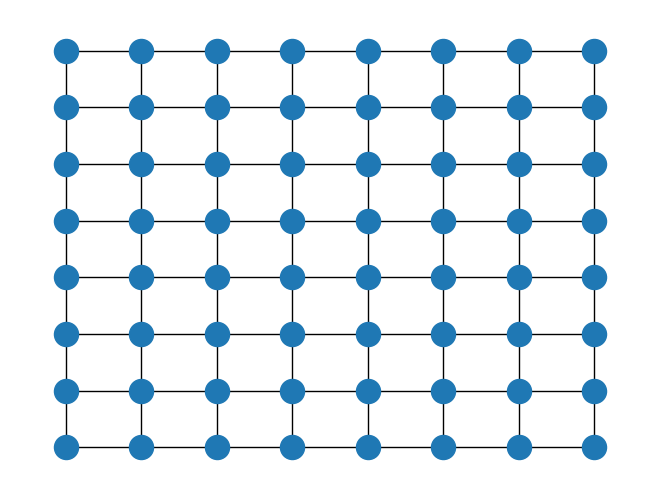

In [463]:
chessboard_graph(8)
# places = jnp.linspace(0, 1, 8)
# positions = jnp.array([[[x, y] for x in places] for y in places])
# G = nx.grid_2d_graph(8, 8)
# nx.draw(G, pos=positions)

(8, 8, 2)
(112, 1)


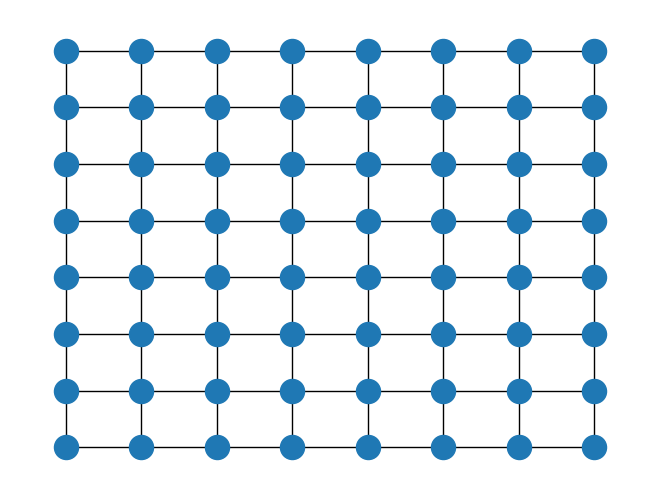

In [464]:
num_cities = 8
# graph = build_d_regular(num_cities, 3)
# graph = build_complete_graph(num_cities)
graph = chessboard_graph(num_cities)

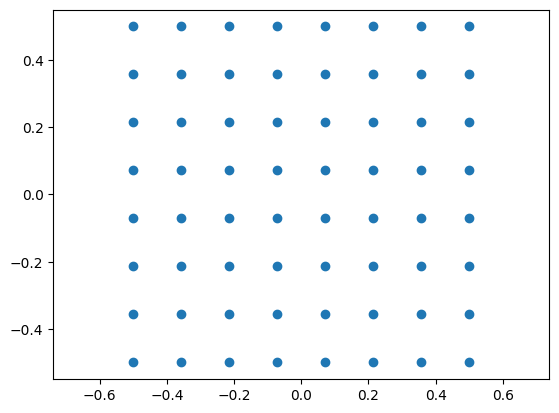

In [465]:
import matplotlib.pyplot as plt

cities = graph.nodes

plt.scatter(cities[:, 0], cities[:, 1])
plt.axis("equal")
plt.show()

In [466]:
state, train_metric = train(graph)

Step 0 Loss 544.2794799804688
Step 100 Loss 148.41744995117188
Step 200 Loss 148.0487823486328
Step 300 Loss 147.99703979492188
Step 400 Loss 147.897705078125
Step 500 Loss 147.88174438476562
Step 600 Loss 147.87298583984375
Step 700 Loss 147.86782836914062
Step 800 Loss 147.8645782470703
Step 900 Loss 147.8660430908203
Step 1000 Loss 147.86123657226562
Step 1100 Loss 147.8597869873047
Step 1200 Loss 147.8701934814453
Step 1300 Loss 147.85833740234375
Step 1400 Loss 147.85809326171875
Step 1500 Loss 147.8575897216797
Step 1600 Loss 147.8571319580078
Step 1700 Loss 147.8770294189453
Step 1800 Loss 147.85665893554688
Step 1900 Loss 147.85684204101562
Step 2000 Loss 147.8563690185547
Step 2100 Loss 147.856201171875
Step 2200 Loss 147.8566131591797
Step 2300 Loss 147.85604858398438
Step 2400 Loss 148.06973266601562
Step 2500 Loss 147.85589599609375
Step 2600 Loss 147.85581970214844
Step 2700 Loss 147.85580444335938
Step 2800 Loss 147.85572814941406
Step 2900 Loss 147.856201171875
Step 3000

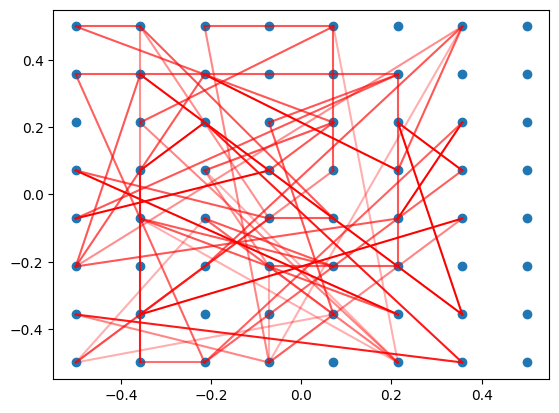

In [467]:
from matrix_helper import plot_tour, adjacency

output = state.apply_fn(
    state.params,
    graph,
    rngs={"dropout": jax.random.PRNGKey(42)},
)

x = output.globals
plot_tour(x, graph.nodes)

X = x.reshape(num_cities**2, num_cities**2)

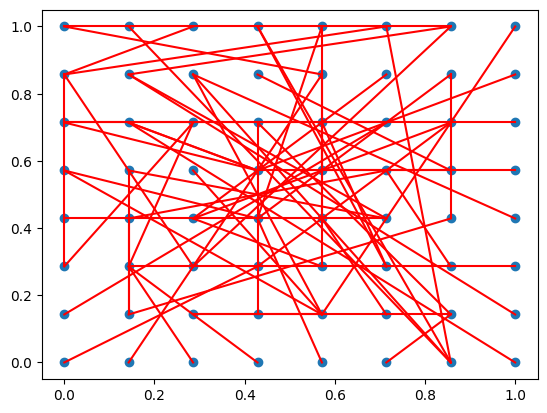

In [448]:
A = adjacency(x, num_cities**2)

maxes = np.argmax(A, axis=0)
TMP = np.zeros_like(X)
TMP[np.arange(num_cities**2), maxes] = 1

points = graph.nodes
plt.scatter(points[:, 0], points[:, 1])

for i in range(num_cities**2):
    plt.plot(
        [points[i, 0], points[maxes[i], 0]],
        [points[i, 1], points[maxes[i], 1]],
        c="r",
    )

In [401]:
TMP

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [402]:
np.sum((1 - np.sum(TMP, axis=0)) ** 2)

162.0

In [403]:
np.sum((1 - np.sum(TMP, axis=1)) ** 2)

0.0

In [382]:
n = num_cities

X = output.globals.reshape(n, n)
W = graph.edges.reshape(n, n)


def hamilton_1(X):
    tmp = 1 - jnp.sum(X, axis=0)
    return tmp.T @ tmp


def hamilton_2(X):
    tmp = 1 - jnp.sum(X, axis=1)
    return tmp.T @ tmp


def tsp(X, W):
    adjacents = X.T @ jnp.roll(X, 1, axis=1)
    return jnp.sum(adjacents * W)


Hamiltonian = hamilton_1(X) + hamilton_2(X)
TSP = tsp(X, W)

TypeError: cannot reshape array of shape (4096,) (size 4096) into shape (8, 8) (size 64)

In [312]:
Hamiltonian

Array(1.1882084e-06, dtype=float32)

In [313]:
TSP

Array(4.228015, dtype=float32)

In [7]:
from jax import make_jaxpr, jit
import jax.numpy as np

In [15]:
# @jit
def foo(bar, baz):
    bar = np.sin(bar)
    baz = np.cos(baz)
    baz = 0
    return bar + baz

In [16]:
make_jaxpr(foo)(1.0, 2.0)

{ lambda ; a:f32[] b:f32[]. let
    c:f32[] = sin a
    _:f32[] = cos b
    d:f32[] = add c 0.0
  in (d,) }

In [17]:
from jax import grad

make_jaxpr(jit(grad(foo)))(1.0, 2.0)

{ lambda ; a:f32[] b:f32[]. let
    c:f32[] = pjit[
      name=foo
      jaxpr={ lambda ; d:f32[] e:f32[]. let
          f:f32[] = sin d
          g:f32[] = cos d
          _:f32[] = cos e
          _:f32[] = add f 0.0
          h:f32[] = mul 1.0 g
        in (h,) }
    ] a b
  in (c,) }

In [18]:
make_jaxpr(grad(foo))(1.0, 2.0)

{ lambda ; a:f32[] b:f32[]. let
    c:f32[] = sin a
    d:f32[] = cos a
    _:f32[] = cos b
    _:f32[] = add c 0.0
    e:f32[] = mul 1.0 d
  in (e,) }

In [80]:
import flax.linen as nn
import numpy as onp

x = np.asarray(onp.random.randn(2, 3))


class myDrop(nn.Module):
    @nn.compact
    def __call__(self, x):
        return nn.Dropout(rate=0.5, deterministic=False, broadcast_dims=[0])(x)

In [81]:
import jax

model = myDrop()
variables = model.init(jax.random.PRNGKey(0), x)

for i in range(42):
    p = model.apply(variables, x, rngs={"dropout": jax.random.PRNGKey(i)})
    print(p)

[[-0.42833662  0.          0.6173843 ]
 [-3.0233817   0.         -0.91450953]]
[[ 0.          2.6639314   0.6173843 ]
 [ 0.          0.6825819  -0.91450953]]
[[-0.42833662  2.6639314   0.6173843 ]
 [-3.0233817   0.6825819  -0.91450953]]
[[0. 0. 0.]
 [0. 0. 0.]]
[[-0.42833662  2.6639314   0.6173843 ]
 [-3.0233817   0.6825819  -0.91450953]]
[[-0.42833662  0.          0.        ]
 [-3.0233817   0.          0.        ]]
[[0.        2.6639314 0.       ]
 [0.        0.6825819 0.       ]]
[[ 0.          2.6639314   0.6173843 ]
 [ 0.          0.6825819  -0.91450953]]
[[-0.42833662  2.6639314   0.6173843 ]
 [-3.0233817   0.6825819  -0.91450953]]
[[0. 0. 0.]
 [0. 0. 0.]]
[[-0.42833662  0.          0.6173843 ]
 [-3.0233817   0.         -0.91450953]]
[[ 0.          0.          0.6173843 ]
 [ 0.          0.         -0.91450953]]
[[-0.42833662  2.6639314   0.        ]
 [-3.0233817   0.6825819   0.        ]]
[[-0.42833662  0.          0.6173843 ]
 [-3.0233817   0.         -0.91450953]]
[[-0.42833662 

TypeError: 'dict' object is not callable